# Monopoly RL Training Analysis

This notebook visualizes training progress for all 10 agents across multiple games.

**Metrics visualized:**
- Win rates over time
- Average rewards per agent
- Learning curves (reward progression)
- Agent comparisons
- Game statistics

In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from collections import defaultdict
import pandas as pd

# Set style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 10

## 1. Load Training Data

In [2]:
# Configuration
CHECKPOINT_DIR = Path('models/checkpoints')
LOG_DIR = Path('logs')

# Find latest history file
history_files = sorted(CHECKPOINT_DIR.glob('history_*.json'))

if not history_files:
    print("No history files found. Make sure training has run and saved checkpoints.")
    print(f"Looking in: {CHECKPOINT_DIR.absolute()}")
else:
    latest_history = history_files[-1]
    print(f"Loading: {latest_history}")
    
    with open(latest_history) as f:
        history = json.load(f)
    
    agent_ids = history['agent_ids']
    games_played = history['games_played']
    wins = history['wins']
    game_history = history['game_history']
    game_rewards = history['game_rewards']
    max_rewards = history['max_rewards']
    
    total_games = len(game_history)
    print(f"\nLoaded {total_games} games")
    print(f"Agents: {', '.join(agent_ids)}")
    print(f"\nGames per agent: {games_played}")

Loading: models\checkpoints\history_000129.json

Loaded 129 games
Agents: alice, bob, charlie, dee, ethel, frankie, greta, harry, irene, jack

Games per agent: {'alice': 59, 'bob': 70, 'charlie': 68, 'dee': 60, 'ethel': 67, 'frankie': 65, 'greta': 66, 'harry': 76, 'irene': 67, 'jack': 61}


## 2. Win Rates Over Time

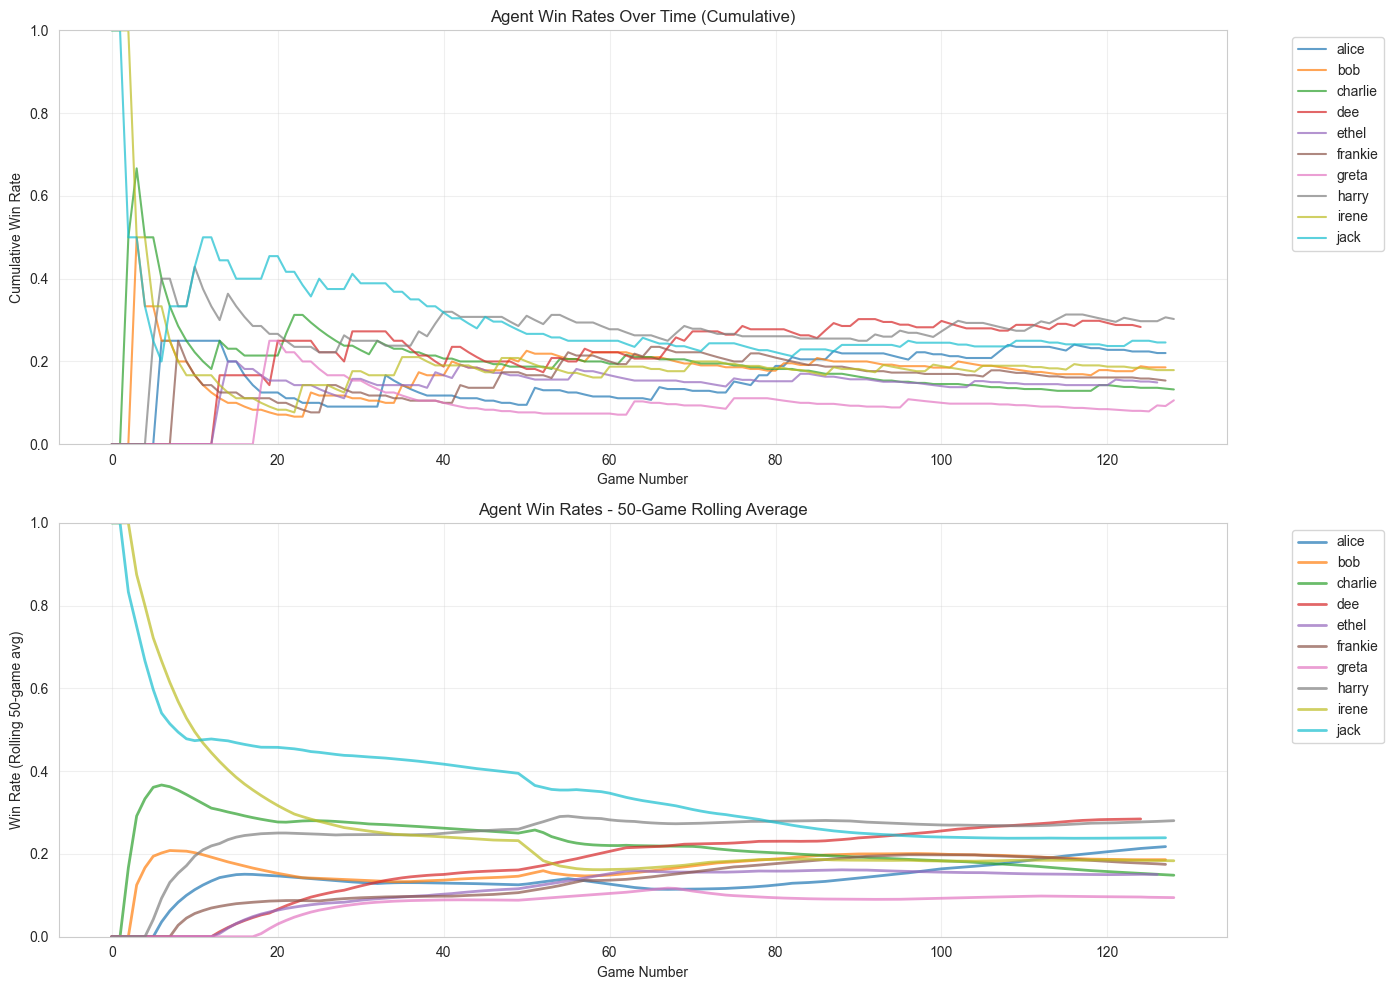


Final Win Rates:
alice       : 0.220 (13/59 wins)
bob         : 0.186 (13/70 wins)
charlie     : 0.132 (9/68 wins)
dee         : 0.283 (17/60 wins)
ethel       : 0.149 (10/67 wins)
frankie     : 0.154 (10/65 wins)
greta       : 0.106 (7/66 wins)
harry       : 0.303 (23/76 wins)
irene       : 0.179 (12/67 wins)
jack        : 0.246 (15/61 wins)


In [3]:
# Calculate cumulative win rates over time
window = 50  # Rolling window for smoothing

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Cumulative win rate
cumulative_wins = {agent_id: [] for agent_id in agent_ids}
cumulative_games = {agent_id: [] for agent_id in agent_ids}

for game_idx, game in enumerate(game_history):
    winner = game['winner']
    participants = game['participants']
    
    for agent_id in agent_ids:
        if agent_id in participants:
            # Agent played this game
            if len(cumulative_games[agent_id]) == 0:
                cumulative_games[agent_id].append(1)
                cumulative_wins[agent_id].append(1 if agent_id == winner else 0)
            else:
                cumulative_games[agent_id].append(cumulative_games[agent_id][-1] + 1)
                cumulative_wins[agent_id].append(
                    cumulative_wins[agent_id][-1] + (1 if agent_id == winner else 0)
                )
        else:
            # Agent didn't play - carry forward previous values
            if len(cumulative_games[agent_id]) > 0:
                cumulative_games[agent_id].append(cumulative_games[agent_id][-1])
                cumulative_wins[agent_id].append(cumulative_wins[agent_id][-1])

# Plot cumulative win rates
for agent_id in agent_ids:
    if cumulative_games[agent_id]:
        win_rates = [
            wins / games if games > 0 else 0 
            for wins, games in zip(cumulative_wins[agent_id], cumulative_games[agent_id])
        ]
        ax1.plot(win_rates, label=agent_id, alpha=0.7)

ax1.set_xlabel('Game Number')
ax1.set_ylabel('Cumulative Win Rate')
ax1.set_title('Agent Win Rates Over Time (Cumulative)')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_ylim([0, 1])

# Plot 2: Rolling window win rate
for agent_id in agent_ids:
    if cumulative_games[agent_id] and len(cumulative_games[agent_id]) >= window:
        win_rates = [
            wins / games if games > 0 else 0 
            for wins, games in zip(cumulative_wins[agent_id], cumulative_games[agent_id])
        ]
        # Rolling average
        rolling_wr = pd.Series(win_rates).rolling(window=window, min_periods=1).mean()
        ax2.plot(rolling_wr, label=agent_id, alpha=0.7, linewidth=2)

ax2.set_xlabel('Game Number')
ax2.set_ylabel(f'Win Rate (Rolling {window}-game avg)')
ax2.set_title(f'Agent Win Rates - {window}-Game Rolling Average')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_ylim([0, 1])

plt.tight_layout()
plt.show()

# Print final win rates
print("\nFinal Win Rates:")
print("="*40)
for agent_id in sorted(agent_ids):
    wr = wins[agent_id] / games_played[agent_id] if games_played[agent_id] > 0 else 0
    print(f"{agent_id:12s}: {wr:.3f} ({wins[agent_id]}/{games_played[agent_id]} wins)")

## 3. Average Rewards Over Time

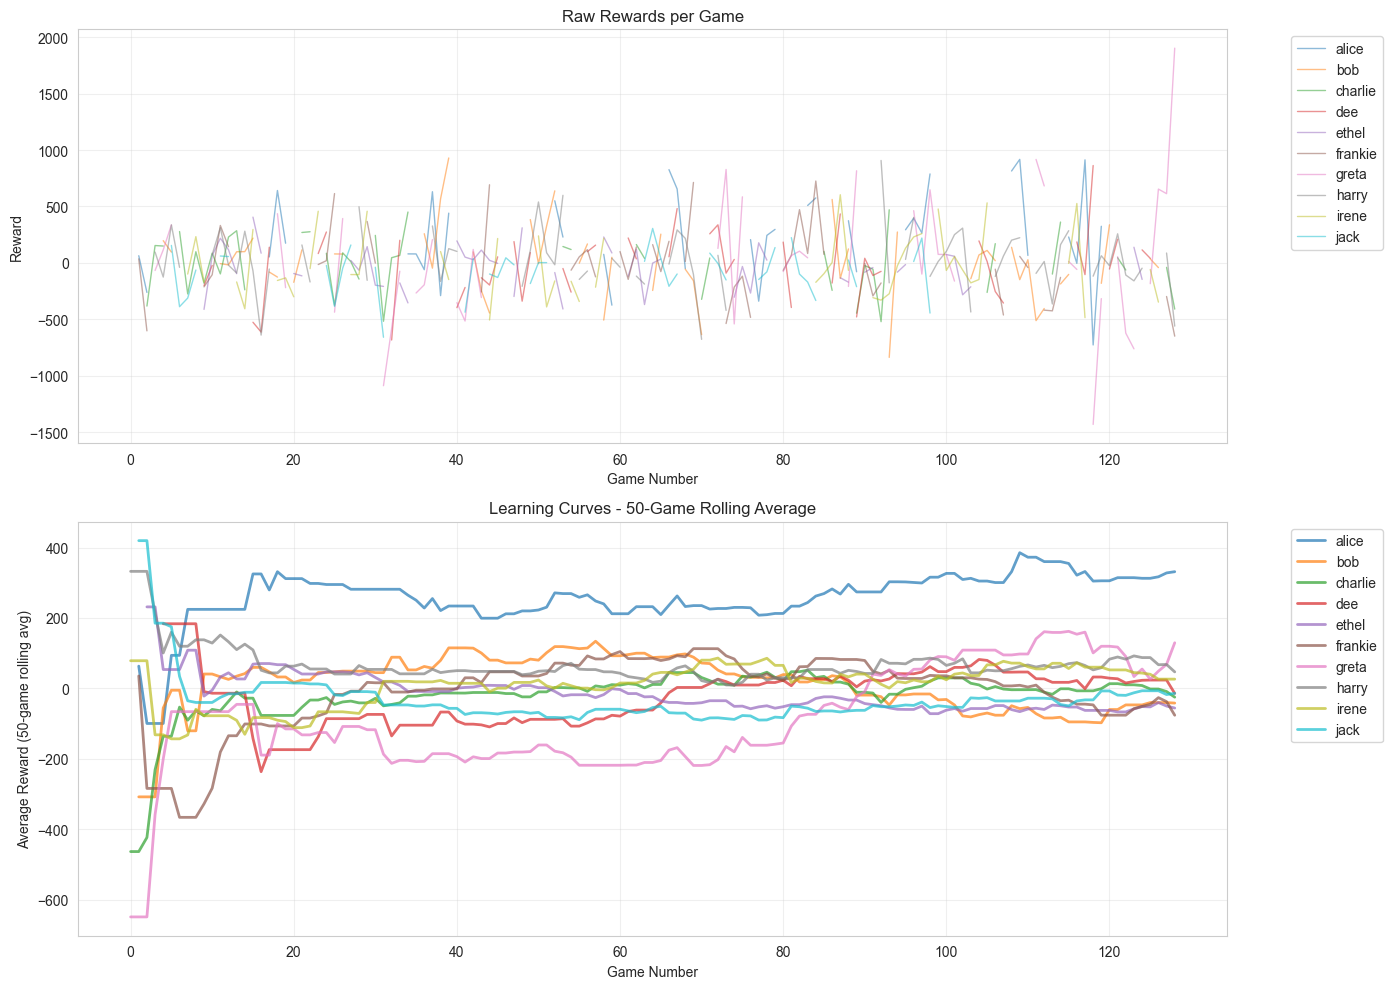


Reward Statistics:
Agent              Mean        Std        Min        Max
------------------------------------------------------------
alice            272.48     345.67    -727.60     917.80
bob                8.21     332.24    -837.90     930.20
charlie           -6.78     246.12    -713.25     470.85
dee              -10.05     297.36    -785.15     863.15
ethel            -30.25     176.79    -412.20     405.70
frankie          -12.37     303.71    -649.60     725.75
greta            -19.20     518.54   -1432.25    1904.15
harry             43.23     276.49    -677.85     907.75
irene             21.82     297.32    -506.20    1040.85
jack             -45.93     219.41    -659.35     590.65


In [4]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))

# Plot 1: Raw rewards over time
for agent_id in agent_ids:
    rewards = [r if r is not None else np.nan for r in game_rewards[agent_id]]
    ax1.plot(rewards, label=agent_id, alpha=0.5, linewidth=1)

ax1.set_xlabel('Game Number')
ax1.set_ylabel('Reward')
ax1.set_title('Raw Rewards per Game')
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)

# Plot 2: Rolling average rewards
window = 50
for agent_id in agent_ids:
    rewards = [r if r is not None else np.nan for r in game_rewards[agent_id]]
    rolling_avg = pd.Series(rewards).rolling(window=window, min_periods=1).mean()
    ax2.plot(rolling_avg, label=agent_id, alpha=0.7, linewidth=2)

ax2.set_xlabel('Game Number')
ax2.set_ylabel(f'Average Reward ({window}-game rolling avg)')
ax2.set_title(f'Learning Curves - {window}-Game Rolling Average')
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print reward statistics
print("\nReward Statistics:")
print("="*60)
print(f"{'Agent':12s} {'Mean':>10s} {'Std':>10s} {'Min':>10s} {'Max':>10s}")
print("-"*60)
for agent_id in sorted(agent_ids):
    rewards = [r for r in game_rewards[agent_id] if r is not None]
    if rewards:
        print(f"{agent_id:12s} {np.mean(rewards):>10.2f} {np.std(rewards):>10.2f} "
              f"{np.min(rewards):>10.2f} {np.max(rewards):>10.2f}")
    else:
        print(f"{agent_id:12s} {'N/A':>10s} {'N/A':>10s} {'N/A':>10s} {'N/A':>10s}")

## 4. Agent Comparison - Final Performance

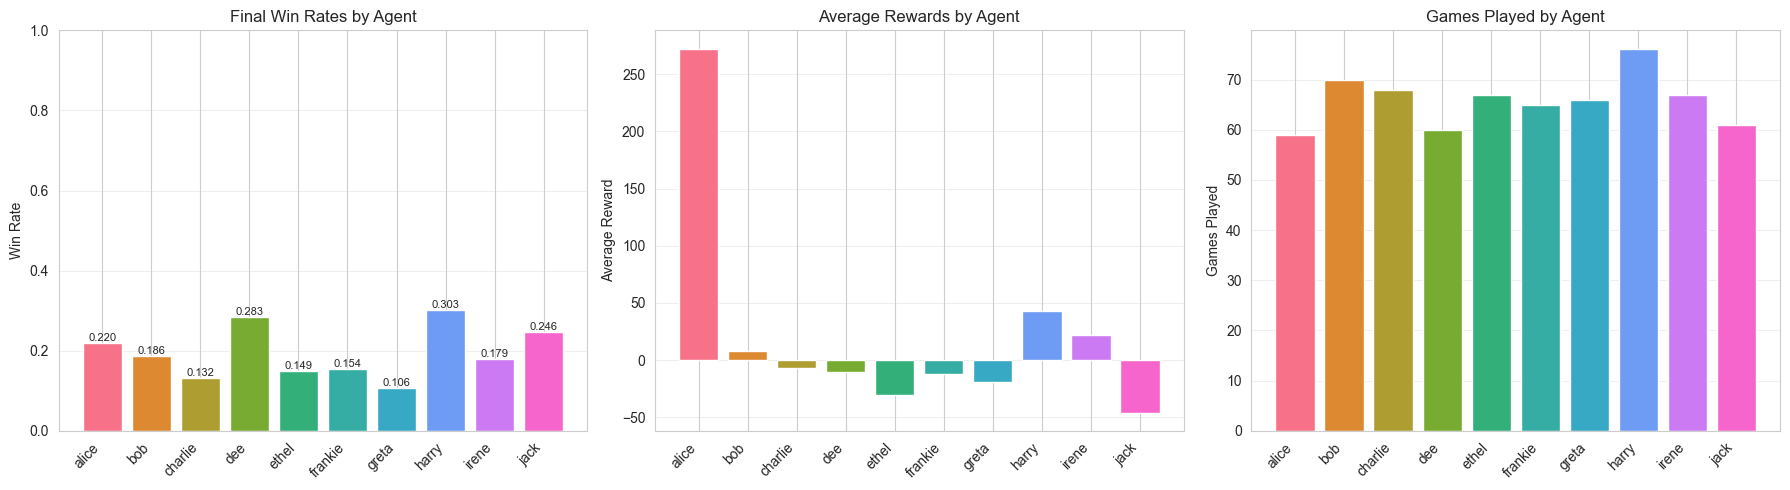

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Prepare data
agent_names = sorted(agent_ids)
win_rates_list = [wins[a] / games_played[a] if games_played[a] > 0 else 0 for a in agent_names]
avg_rewards_list = [
    np.mean([r for r in game_rewards[a] if r is not None]) if any(r is not None for r in game_rewards[a]) else 0 
    for a in agent_names
]
max_rewards_list = [max_rewards[a] if max_rewards[a] is not None else 0 for a in agent_names]

# Plot 1: Win Rates
bars1 = axes[0].bar(range(len(agent_names)), win_rates_list, color=sns.color_palette('husl', len(agent_names)))
axes[0].set_xticks(range(len(agent_names)))
axes[0].set_xticklabels(agent_names, rotation=45, ha='right')
axes[0].set_ylabel('Win Rate')
axes[0].set_title('Final Win Rates by Agent')
axes[0].set_ylim([0, 1])
axes[0].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, bar in enumerate(bars1):
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{win_rates_list[i]:.3f}',
                ha='center', va='bottom', fontsize=8)

# Plot 2: Average Rewards
bars2 = axes[1].bar(range(len(agent_names)), avg_rewards_list, color=sns.color_palette('husl', len(agent_names)))
axes[1].set_xticks(range(len(agent_names)))
axes[1].set_xticklabels(agent_names, rotation=45, ha='right')
axes[1].set_ylabel('Average Reward')
axes[1].set_title('Average Rewards by Agent')
axes[1].grid(True, alpha=0.3, axis='y')

# Plot 3: Games Played
games_played_list = [games_played[a] for a in agent_names]
bars3 = axes[2].bar(range(len(agent_names)), games_played_list, color=sns.color_palette('husl', len(agent_names)))
axes[2].set_xticks(range(len(agent_names)))
axes[2].set_xticklabels(agent_names, rotation=45, ha='right')
axes[2].set_ylabel('Games Played')
axes[2].set_title('Games Played by Agent')
axes[2].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

## 5. Head-to-Head Win Matrix

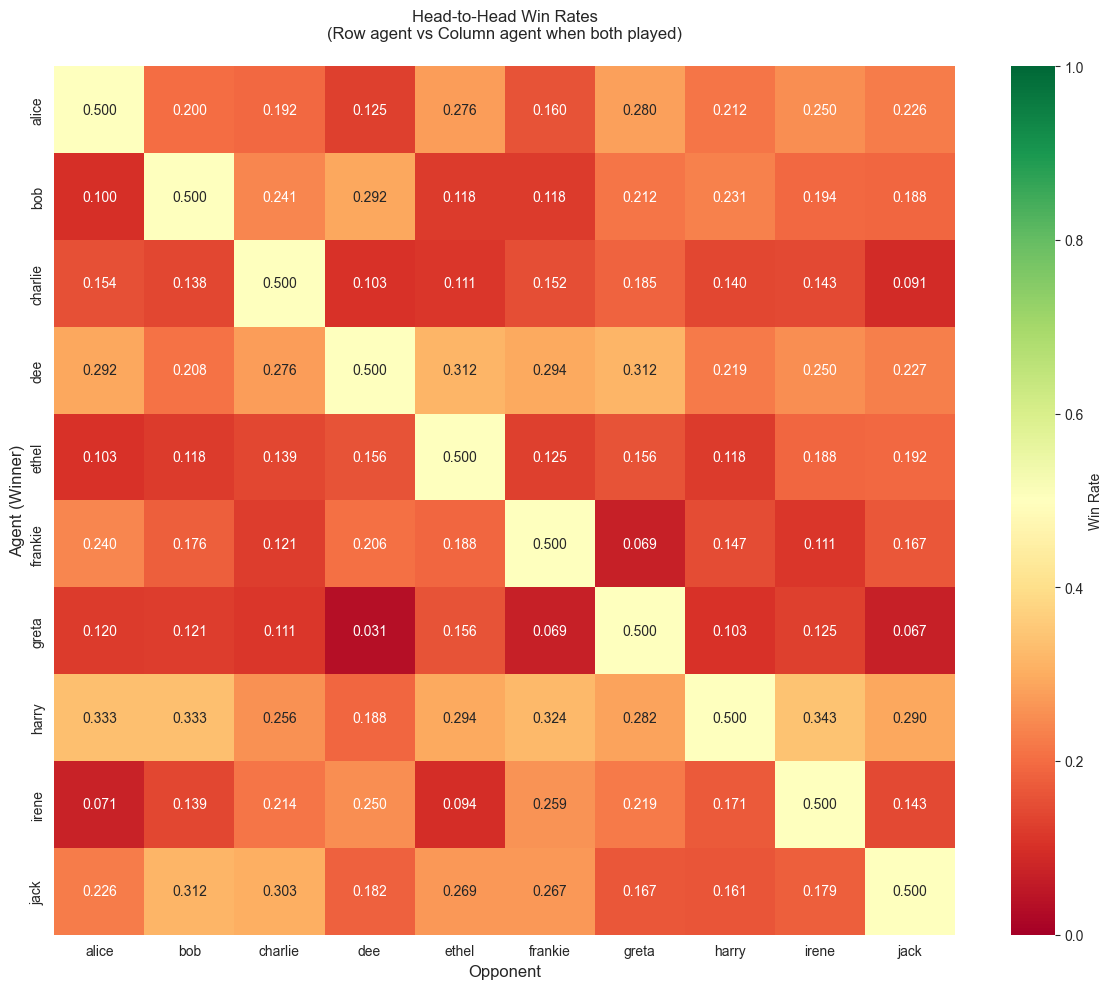


Note: Values show the win rate of the row agent against the column agent
when both agents participated in the same game.


In [6]:
# Build head-to-head win matrix
# Matrix[i][j] = number of times agent i beat agent j when both played
h2h_wins = {a: {b: 0 for b in agent_ids} for a in agent_ids}
h2h_games = {a: {b: 0 for b in agent_ids} for a in agent_ids}

for game in game_history:
    winner = game['winner']
    participants = game['participants']
    
    # For each pair of participants
    for i, agent_a in enumerate(participants):
        for agent_b in participants[i+1:]:
            h2h_games[agent_a][agent_b] += 1
            h2h_games[agent_b][agent_a] += 1
            
            if winner == agent_a:
                h2h_wins[agent_a][agent_b] += 1
            elif winner == agent_b:
                h2h_wins[agent_b][agent_a] += 1

# Calculate win rates
h2h_matrix = np.zeros((len(agent_ids), len(agent_ids)))
for i, agent_a in enumerate(agent_ids):
    for j, agent_b in enumerate(agent_ids):
        if i == j:
            h2h_matrix[i][j] = 0.5  # Diagonal
        elif h2h_games[agent_a][agent_b] > 0:
            h2h_matrix[i][j] = h2h_wins[agent_a][agent_b] / h2h_games[agent_a][agent_b]
        else:
            h2h_matrix[i][j] = 0.5  # No games played

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(h2h_matrix, annot=True, fmt='.3f', cmap='RdYlGn', 
            xticklabels=agent_ids, yticklabels=agent_ids,
            vmin=0, vmax=1, center=0.5, cbar_kws={'label': 'Win Rate'})
plt.title('Head-to-Head Win Rates\n(Row agent vs Column agent when both played)', pad=20)
plt.ylabel('Agent (Winner)', fontsize=12)
plt.xlabel('Opponent', fontsize=12)
plt.tight_layout()
plt.show()

print("\nNote: Values show the win rate of the row agent against the column agent")
print("when both agents participated in the same game.")

## 6. Training Summary Statistics

In [7]:
print("\n" + "="*70)
print("TRAINING SUMMARY")
print("="*70)

print(f"\nTotal Games: {total_games}")
print(f"Total Agents: {len(agent_ids)}")

# Calculate statistics
avg_players_per_game = np.mean([len(g['participants']) for g in game_history])
print(f"\nAverage players per game: {avg_players_per_game:.2f}")

# Win distribution
print(f"\n{'Agent Performance (Sorted by Win Rate)':^70}")
print("-"*70)
print(f"{'Rank':<6} {'Agent':<12} {'Games':<8} {'Wins':<8} {'Win Rate':<12} {'Avg Reward':<15}")
print("-"*70)

# Sort by win rate
agent_stats = []
for agent_id in agent_ids:
    wr = wins[agent_id] / games_played[agent_id] if games_played[agent_id] > 0 else 0
    rewards = [r for r in game_rewards[agent_id] if r is not None]
    avg_reward = np.mean(rewards) if rewards else 0
    agent_stats.append((agent_id, games_played[agent_id], wins[agent_id], wr, avg_reward))

agent_stats.sort(key=lambda x: x[3], reverse=True)

for rank, (agent_id, games, wins_count, wr, avg_reward) in enumerate(agent_stats, 1):
    print(f"{rank:<6} {agent_id:<12} {games:<8} {wins_count:<8} {wr:>10.3f}  {avg_reward:>12.2f}")

print("="*70)


TRAINING SUMMARY

Total Games: 129
Total Agents: 10

Average players per game: 5.11

                Agent Performance (Sorted by Win Rate)                
----------------------------------------------------------------------
Rank   Agent        Games    Wins     Win Rate     Avg Reward     
----------------------------------------------------------------------
1      harry        76       23            0.303         43.23
2      dee          60       17            0.283        -10.05
3      jack         61       15            0.246        -45.93
4      alice        59       13            0.220        272.48
5      bob          70       13            0.186          8.21
6      irene        67       12            0.179         21.82
7      frankie      65       10            0.154        -12.37
8      ethel        67       10            0.149        -30.25
9      charlie      68       9             0.132         -6.78
10     greta        66       7             0.106        -19.20


## 7. Export Results to CSV

In [8]:
# Create DataFrame with all agent statistics
stats_data = []
for agent_id in agent_ids:
    rewards = [r for r in game_rewards[agent_id] if r is not None]
    stats_data.append({
        'Agent': agent_id,
        'Games_Played': games_played[agent_id],
        'Wins': wins[agent_id],
        'Win_Rate': wins[agent_id] / games_played[agent_id] if games_played[agent_id] > 0 else 0,
        'Avg_Reward': np.mean(rewards) if rewards else 0,
        'Std_Reward': np.std(rewards) if rewards else 0,
        'Min_Reward': np.min(rewards) if rewards else 0,
        'Max_Reward': max_rewards[agent_id] if max_rewards[agent_id] is not None else 0
    })

df_stats = pd.DataFrame(stats_data)
df_stats = df_stats.sort_values('Win_Rate', ascending=False)

# Save to CSV
output_file = 'training_results.csv'
df_stats.to_csv(output_file, index=False)
print(f"Results exported to {output_file}")

# Display table
print("\nAgent Statistics:")
print(df_stats.to_string(index=False))

Results exported to training_results.csv

Agent Statistics:
  Agent  Games_Played  Wins  Win_Rate  Avg_Reward  Std_Reward  Min_Reward  Max_Reward
  harry            76    23  0.302632   43.234868  276.488668     -677.85      907.75
    dee            60    17  0.283333  -10.050833  297.356018     -785.15      863.15
   jack            61    15  0.245902  -45.925410  219.406432     -659.35      590.65
  alice            59    13  0.220339  272.483898  345.672892     -727.60      917.80
    bob            70    13  0.185714    8.210714  332.243286     -837.90      930.20
  irene            67    12  0.179104   21.818657  297.322975     -506.20     1040.85
frankie            65    10  0.153846  -12.372308  303.714915     -649.60      725.75
  ethel            67    10  0.149254  -30.247015  176.789822     -412.20      405.70
charlie            68     9  0.132353   -6.777206  246.119532     -713.25      470.85
  greta            66     7  0.106061  -19.202273  518.538682    -1432.25     19

## 8. Recent Performance (Last 100 Games)


Recent Performance (Last 100 Games):
Agent        Games    Wins     Recent Win Rate     
------------------------------------------------------------
harry        57       18                    0.316
dee          52       15                    0.288
alice        48       12                    0.250
bob          53       11                    0.208
jack         45       9                     0.200
irene        51       10                    0.196
ethel        51       8                     0.157
frankie      51       8                     0.157
greta        54       5                     0.093
charlie      47       4                     0.085


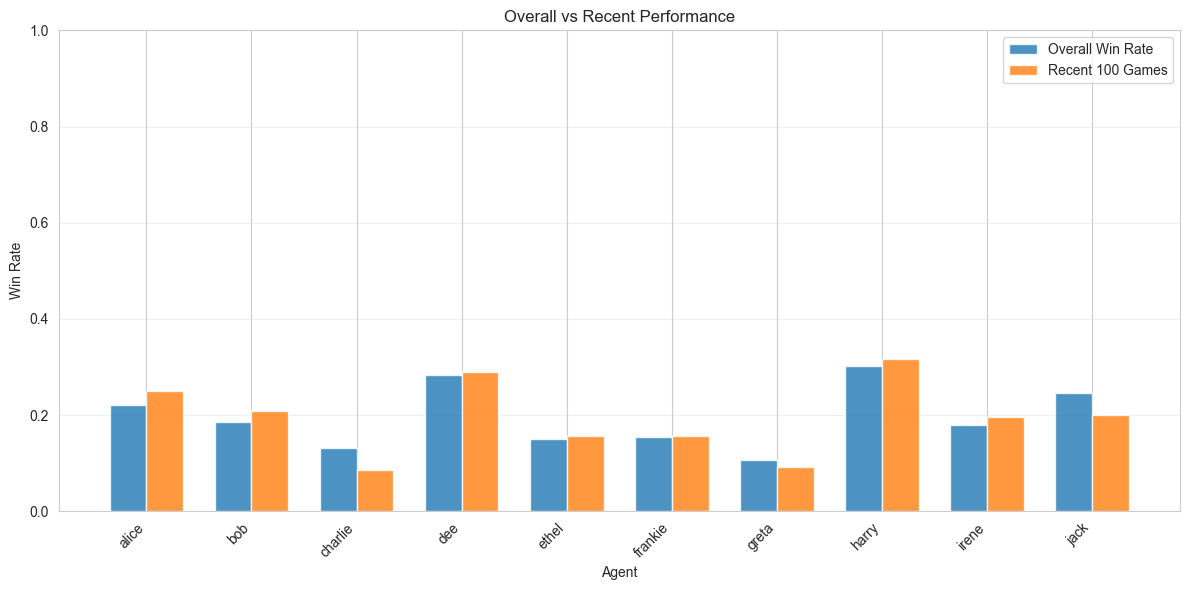

In [9]:
# Analyze last N games to see recent performance
recent_n = min(100, total_games)
recent_games = game_history[-recent_n:]

recent_wins = {agent_id: 0 for agent_id in agent_ids}
recent_played = {agent_id: 0 for agent_id in agent_ids}

for game in recent_games:
    winner = game['winner']
    participants = game['participants']
    
    for agent_id in participants:
        recent_played[agent_id] += 1
        if agent_id == winner:
            recent_wins[agent_id] += 1

print(f"\nRecent Performance (Last {recent_n} Games):")
print("="*60)
print(f"{'Agent':<12} {'Games':<8} {'Wins':<8} {'Recent Win Rate':<20}")
print("-"*60)

for agent_id in sorted(agent_ids, 
                       key=lambda a: recent_wins[a]/recent_played[a] if recent_played[a] > 0 else 0, 
                       reverse=True):
    recent_wr = recent_wins[agent_id] / recent_played[agent_id] if recent_played[agent_id] > 0 else 0
    print(f"{agent_id:<12} {recent_played[agent_id]:<8} {recent_wins[agent_id]:<8} {recent_wr:>18.3f}")

# Plot comparison: overall vs recent
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(agent_ids))
width = 0.35

overall_wr = [wins[a] / games_played[a] if games_played[a] > 0 else 0 for a in agent_ids]
recent_wr_list = [recent_wins[a] / recent_played[a] if recent_played[a] > 0 else 0 for a in agent_ids]

ax.bar(x - width/2, overall_wr, width, label='Overall Win Rate', alpha=0.8)
ax.bar(x + width/2, recent_wr_list, width, label=f'Recent {recent_n} Games', alpha=0.8)

ax.set_xlabel('Agent')
ax.set_ylabel('Win Rate')
ax.set_title(f'Overall vs Recent Performance')
ax.set_xticks(x)
ax.set_xticklabels(agent_ids, rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
ax.set_ylim([0, 1])

plt.tight_layout()
plt.show()